## 1. import libraries

In [6]:
pip install feature-engine

In [7]:
!pip install --upgrade scikit-learn feature-engine

In [9]:
pip install scikit-learn feature-engine

In [202]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from feature_engine.outliers import Winsorizer
from sklearn.metrics.pairwise import rbf_kernel
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from feature_engine.encoding import RareLabelEncoder,MeanEncoder,CountFrequencyEncoder
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,PowerTransformer, FunctionTransformer,StandardScaler

## 2. display setting

In [12]:
pd.set_option("display.max_columns",None) # sometime pandas doesnot show all the columns(usually during we have 50 or 100 columns), so using this code we we force th pandas to show all the columns

In [13]:
sklearn.set_config(transform_output="pandas") # usually pandas return numpy array after tranformation but if we want to return the datafram after tranformation then we use this line of code

In [14]:
warnings.filterwarnings("ignore") # this will remove the warning which we got during running a cell

## 3.Read the data
- note: all feature engineering or data pre-processing works are done on training data 

In [16]:
train=pd.read_csv("train.csv")
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


In [344]:
pd.read_csv("flight_price.csv")

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [18]:
x_train=train.drop(columns="price")
y_train=train.price.copy()

## 4.Transformation operation (columns-wise)

In [20]:
x_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 airline

In [22]:
x_train.airline

0            Jet Airways
1              Air India
2              Air India
3                Vistara
4                Vistara
             ...        
635             Air Asia
636          Jet Airways
637               Indigo
638    Multiple Carriers
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [23]:
air_transformer = Pipeline(steps=[
                      ("imputer",SimpleImputer(strategy="most_frequent")),
                      ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
                       ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
                          ])

air_transformer.fit_transform(x_train.loc[:,["airline"]]) # here, if we write x_train only inside the bracket then it will apply the tranformation to all the columns

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,0.0,1.0,0.0


- One-hot encoding is a popular technique used to convert categorical variables into a numerical format that machine learning algorithms can work with. Categorical data, such as "red," "blue," or "green," cannot be directly used in most machine learning algorithms that require numerical input. One-hot encoding solves this problem by converting each category into a binary vector.

## 4.2 Date_of_journey

In [26]:
x_train.date_of_journey

0      2019-06-21
1      2019-05-18
2      2019-06-12
3      2019-04-01
4      2019-06-06
          ...    
635    2019-04-12
636    2019-05-09
637    2019-05-15
638    2019-05-15
639    2019-05-21
Name: date_of_journey, Length: 640, dtype: object

In [27]:
# now, we extract data_time feature
from feature_engine.datetime import DatetimeFeatures

In [28]:
feature_to_extract = ["month","day_of_month","week","day_of_week","day_of_year"] # here, we not write "year" beacuse it has only one value i.e 2019.so, we only write month and year

doj_transformer = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())  # we use minmaxscaler beacuse the value of date_of_journey_month is in single digit, date_of_journey_day_of_month & date_of_journey_week is in double digit and date_of_journey_day_of_year is in triple digit so, we need to scale down to increase the performance of model.minmaxscaling scale the covert the original data value in range of 0 to 1 
])

doj_transformer.fit_transform(x_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_day_of_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.769231,0.941176,0.666667,0.949153
1,0.666667,0.653846,0.647059,0.833333,0.661017
2,1.000000,0.423077,0.882353,0.333333,0.872881
3,0.333333,0.000000,0.294118,0.000000,0.262712
4,1.000000,0.192308,0.823529,0.500000,0.822034
...,...,...,...,...,...
635,0.333333,0.423077,0.352941,0.666667,0.355932
636,0.666667,0.307692,0.588235,0.500000,0.584746
637,0.666667,0.538462,0.647059,0.333333,0.635593
638,0.666667,0.538462,0.647059,0.333333,0.635593


In [29]:
x_train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info


### 4.3 Source & destination

In [31]:
x_train.source

0        Mumbai
1         Delhi
2       Kolkata
3       Kolkata
4       Kolkata
         ...   
635    Banglore
636     Kolkata
637    Banglore
638       Delhi
639     Kolkata
Name: source, Length: 640, dtype: object

In [32]:
x_train.destination

0      Hyderabad
1         Cochin
2       Banglore
3       Banglore
4       Banglore
         ...    
635        Delhi
636     Banglore
637        Delhi
638       Cochin
639     Banglore
Name: destination, Length: 640, dtype: object

In [33]:
location_subset=x_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Banglore,Delhi
636,Kolkata,Banglore
637,Banglore,Delhi
638,Delhi,Cochin


In [34]:
location_pipe1=Pipeline(
    steps=[
        ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
        ("encoder",MeanEncoder()),  # meanencoder give huge value so, we need to tranform this using powertranformer
        ("scaler",PowerTransformer()) # it find such lambda for each columns such that to make tranformed column as symmetry as possible 
    ])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,-1.855189,-0.904387
1,1.010384,1.009568
2,0.001513,-0.024692
3,0.001513,-0.024692
4,0.001513,-0.024692
...,...,...
635,-1.066757,-1.786597
636,0.001513,-0.024692
637,-1.066757,-1.786597
638,1.010384,1.009568


In [35]:
np.union1d(
    x_train.source.unique(),
    x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [36]:
def is_north(x):
    columns= x.columns.to_list()
    north_cities = ["Delhi","Kolkata","New Delhi","Mumbai"]
    return(
        x
        .assign(**{
            f"{col}_is_north" : x.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

# is_north(location_subset) this will not work inside column  tranformer and it is not sklearn competable so, we need to make sklearn competable
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,0,1
638,1,0


In [37]:
# now we need to add rareencoding, meanencoding, powertransformtion with is_north function
location_transformer = FeatureUnion(transformer_list=[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.855189,-0.904387,1,0
1,1.010384,1.009568,1,0
2,0.001513,-0.024692,1,0
3,0.001513,-0.024692,1,0
4,0.001513,-0.024692,1,0
...,...,...,...,...
635,-1.066757,-1.786597,0,1
636,0.001513,-0.024692,1,0
637,-1.066757,-1.786597,0,1
638,1.010384,1.009568,1,0


## 4.5 dep_time & arrival_time

In [39]:
x_train.dep_time

0      10:20:00
1      09:00:00
2      09:10:00
3      20:20:00
4      17:00:00
         ...   
635    04:55:00
636    09:35:00
637    06:05:00
638    08:45:00
639    20:00:00
Name: dep_time, Length: 640, dtype: object

In [40]:
x_train.arrival_time

0      11:50:00
1      07:40:00
2      11:05:00
3      22:55:00
4      10:45:00
         ...   
635    07:45:00
636    21:05:00
637    08:50:00
638    21:00:00
639    12:00:00
Name: arrival_time, Length: 640, dtype: object

- in the above data we dont have value of second in dep_time and arrival_time

In [42]:
time_subset = x_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,10:20:00,11:50:00
1,09:00:00,07:40:00
2,09:10:00,11:05:00
3,20:20:00,22:55:00
4,17:00:00,10:45:00
...,...,...
635,04:55:00,07:45:00
636,09:35:00,21:05:00
637,06:05:00,08:50:00
638,08:45:00,21:00:00


In [43]:
time_pipe1=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler()) # range the data to 0 to 1
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.434783,0.363636,0.478261,0.909091
1,0.391304,0.000000,0.304348,0.727273
2,0.391304,0.181818,0.478261,0.090909
3,0.869565,0.363636,0.956522,1.000000
4,0.739130,0.000000,0.434783,0.818182
...,...,...,...,...
635,0.173913,1.000000,0.304348,0.818182
636,0.391304,0.636364,0.913043,0.090909
637,0.260870,0.090909,0.347826,0.909091
638,0.347826,0.818182,0.913043,0.000000


In [44]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,morning
2,morning,morning
3,night,night
4,evening,morning
...,...,...
635,morning,morning
636,morning,night
637,morning,morning
638,morning,night


In [45]:
time_pipe2=Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.932584
1,1.000000,0.932584
2,1.000000,0.932584
3,0.135747,1.000000
4,0.185520,0.932584
...,...,...
635,1.000000,0.932584
636,1.000000,1.000000
637,1.000000,0.932584
638,1.000000,1.000000


In [46]:
# now, we need to add time_pipe1 and time_pipe2 together. so, we use featureunion class of sklearn

time_transformer = FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.434783,0.363636,0.478261,0.909091,1.000000,0.932584
1,0.391304,0.000000,0.304348,0.727273,1.000000,0.932584
2,0.391304,0.181818,0.478261,0.090909,1.000000,0.932584
3,0.869565,0.363636,0.956522,1.000000,0.135747,1.000000
4,0.739130,0.000000,0.434783,0.818182,0.185520,0.932584
...,...,...,...,...,...,...
635,0.173913,1.000000,0.304348,0.818182,1.000000,0.932584
636,0.391304,0.636364,0.913043,0.090909,1.000000,1.000000
637,0.260870,0.090909,0.347826,0.909091,1.000000,0.932584
638,0.347826,0.818182,0.913043,0.000000,1.000000,1.000000


## 4.6 Duration

In [48]:
x_train.duration

0        90
1      1360
2      1555
3      1595
4      1065
       ... 
635     170
636     690
637     165
638     735
639     960
Name: duration, Length: 640, dtype: int64

In [49]:
# RBF Percentile similarities(RBF Kernel)
# RBF Kernel is a function and it calulate the similrities b/w two values.similarities are check by how two number close toeach other . for this we use euclidian distance
# for this we use sklearn ka rbf kernel
# we make class beacuse sklearn told us to make class
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [50]:
RBFPercentileSimilarity().fit_transform(x_train)   # if we pass whiole x_train, the it will automatically identify the numeric columns and run the function on them

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,1.668157e-314,0.0,0.000000,1.000000,0.904837,0.904837
1,0.000000e+00,0.0,0.000000,0.904837,1.000000,1.000000
2,0.000000e+00,0.0,0.000000,0.670320,0.904837,0.904837
3,0.000000e+00,0.0,0.000000,0.904837,1.000000,1.000000
4,0.000000e+00,0.0,0.000000,0.904837,1.000000,1.000000
...,...,...,...,...,...,...
635,8.208500e-02,0.0,0.000000,1.000000,0.904837,0.904837
636,0.000000e+00,0.0,0.000000,0.904837,1.000000,1.000000
637,4.539993e-05,0.0,0.000000,1.000000,0.904837,0.904837
638,0.000000e+00,0.0,0.000000,0.904837,1.000000,1.000000


- here, for example: if we take duration columns as input columns , after that we calculate the percentile i.e 25 percentile, 50 percentile and 75 percentile of duration columns and then caluculate how much a element of duration columns close to 25, 50 and 75 percentiles and this is calculate by euclidian distance and that is the answer .

In [52]:
duration_pipe1 =Pipeline(steps = [
    ("rbf",RBFPercentileSimilarity()),
    ("scaler",PowerTransformer())
])

duration_union = FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",StandardScaler())
]
)


# now, we first need to handle outlier(using concept of iqr i.e if above (75 percentile + 1.5IQR) and below (25 percentile - 1.5IQR) wil consider as outlier. here we replace outlier which are found durationc columns with the limit of outlier if it is below 25 percentile then replace it with 25 percentile value and it it is above 75 percentile the replace it with 75 percentile) , imputer and then apply the above duration_union
duration_tranformer = Pipeline(
    steps =[
        ("outliers", Winsorizer(capping_method = "iqr", fold=1.5))  # for outlier replacement we need to use winsorizer()
        ,("imputer",SimpleImputer(strategy = "median")),
        ("union",duration_union)
    ]
    
)

duration_tranformer.fit_transform(x_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.364072,-0.132454,-0.099279,-1.100128
1,-0.364072,-0.132454,-0.099279,1.444835
2,-0.364072,-0.132454,-0.099279,1.835597
3,-0.364072,-0.132454,-0.099279,1.915754
4,-0.364072,-0.132454,-0.099279,0.853682
...,...,...,...,...
635,2.649340,-0.132454,-0.099279,-0.939815
636,-0.364072,-0.132454,-0.099279,0.102217
637,-0.359672,-0.132454,-0.099279,-0.949835
638,-0.364072,-0.132454,-0.099279,0.192393


## 4.6 total_stops

In [54]:
x_train.total_stops

0      0.0
1      1.0
2      2.0
3      1.0
4      1.0
      ... 
635    0.0
636    1.0
637    0.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [55]:
def is_direct(x):
    return x.assign(is_direct_flight=x.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps = [
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("functranfomer",FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,2.0,0
3,1.0,0
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,0.0,1
638,1.0,0


## 4.7 additional_info

In [57]:
x_train.additional_info

0      In-flight meal not included
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [58]:
info_pipe1 = Pipeline(steps =[
    ("group",RareLabelEncoder(tol=0.1,n_categories=2,replace_with = "Other")),
    ("encoder",OneHotEncoder(handle_unknown = "ignore",sparse_output = False))
])

info_pipe1.fit_transform(x_train.loc[:,["additional_info"]]).head(30)


,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,1.0,0.0,0.0
9,0.0,1.0,0.0


In [59]:
def have_info(x):
    return x.assign(additional_info=x.additional_info.ne("No Info").astype(int))
    

In [60]:
info_union = FeatureUnion(transformer_list = [
    ("part1",info_pipe1),
    ("pipe2",FunctionTransformer(func=have_info))
])

In [61]:
info_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="constant",fill_value="unknown")),
    ("union",info_union)
])

info_transformer.fit_transform(x_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5. Column tranformer

In [66]:
from sklearn.compose import ColumnTransformer

In [67]:
column_transformer = ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"])     #formet: (name , which tranformation , apply tranformation on whcih columns )
    ,("doj",doj_transformer,["date_of_journey"]),
    ("location",location_transformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("dur",duration_tranformer,["duration"]),
    ("stops",total_stops_transformer,["total_stops"]),
    ("info",info_transformer,["additional_info"])
    ]
    , remainder="passthrough")  # if we want to see all the columns then we use remainder="passthrough"
     

column_transformer.fit_transform(x_train,y_train)  # here, we write x_train only inside the bracket but i see the tranformation only on airline columns because it will only follow the condition what we write inside the tranformer which is "airline" please see just above line( see inside column_transformer variable)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_day_of_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,1.000000,0.769231,0.941176,0.666667,0.949153,-1.855189,-0.904387,1,0,0.434783,0.363636,0.478261,0.909091,1.000000,0.932584,-0.364072,-0.132454,-0.099279,-1.100128,0.0,1,1.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0.666667,0.653846,0.647059,0.833333,0.661017,1.010384,1.009568,1,0,0.391304,0.000000,0.304348,0.727273,1.000000,0.932584,-0.364072,-0.132454,-0.099279,1.444835,1.0,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.000000,0.423077,0.882353,0.333333,0.872881,0.001513,-0.024692,1,0,0.391304,0.181818,0.478261,0.090909,1.000000,0.932584,-0.364072,-0.132454,-0.099279,1.835597,2.0,0,0.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,1.0,0.333333,0.000000,0.294118,0.000000,0.262712,0.001513,-0.024692,1,0,0.869565,0.363636,0.956522,1.000000,0.135747,1.000000,-0.364072,-0.132454,-0.099279,1.915754,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,1.000000,0.192308,0.823529,0.500000,0.822034,0.001513,-0.024692,1,0,0.739130,0.000000,0.434783,0.818182,0.185520,0.932584,-0.364072,-0.132454,-0.099279,0.853682,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.333333,0.423077,0.352941,0.666667,0.355932,-1.066757,-1.786597,0,1,0.173913,1.000000,0.304348,0.818182,1.000000,0.932584,2.649340,-0.132454,-0.099279,-0.939815,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.307692,0.588235,0.500000,0.584746,0.001513,-0.024692,1,0,0.391304,0.636364,0.913043,0.090909,1.000000,1.000000,-0.364072,-0.132454,-0.099279,0.102217,1.0,0,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,0.666667,0.538462,0.647059,0.333333,0.635593,-1.066757,-1.786597,0,1,0.260870,0.090909,0.347826,0.909091,1.000000,0.932584,-0.359672,-0.132454,-0.099279,-0.949835,0.0,1,0.0,1.0,0.0,0
638,0.0,0.0,0.0,1.0,0.0,0.666667,0.538462,0.647059,0.333333,0.635593,1.010384,1.009568,1,0,0.347826,0.818182,0.913043,0.000000,1.000000,1.000000,-0.364072,-0.132454,-0.099279,0.192393,1.0,0,0.0,1.0,0.0,0


## 6. Feature Selection

- SelectBySingleFeaturePerformance is used to select features based on the performance of a single feature when evaluated by a model (in this case, a RandomForestRegressor).

Parameters:

estimator=estimator: The estimator (or model) that will be used to evaluate each feature. Here, it's a RandomForestRegressor.

scoring="r2":

This specifies the performance metric used to evaluate how well the model predicts when using each feature individually.
"r2" refers to the R-squared score, a common performance metric for regression models. It measures how well the predictions from the model explain the variance in the data. The R-squared value ranges from 0 to 1 (where higher is better).
threshold=0.1:

This is the cutoff or threshold for selecting features. If the R-squared score of a feature is below 0.1, the feature will be discarded.
Only features with a score of 0.1 or higher will be selected for the final model.

-How It Works:
Feature Evaluation:

The SelectBySingleFeaturePerformance method evaluates each feature individually by training the specified model (RandomForestRegressor) using just that single feature.
Scoring:

For each feature, the model's performance is measured using the specified scoring metric (r2 in this case).
Thresholding:

After evaluating the performance of each feature, the SelectBySingleFeaturePerformance compares the R-squared score against the threshold of 0.1.
Features with an R-squared score above or equal to 0.1 are kept, while features with an R-squared score below 0.1 are discarded.

In [70]:
estimator = RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)
selector = SelectBySingleFeaturePerformance(
    estimator = estimator,
    scoring="r2",
    threshold=0.1
)

## 7.Put it all together

In [72]:
preprocessor = Pipeline(steps = [
    ("ct",column_transformer),
    ("selector",selector)
])

preprocessor.fit_transform(x_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.941176,0.949153,-1.855189,-0.904387,-0.364072,-1.100128,0.0,1
1,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,-0.364072,1.444835,1.0,0
2,0.0,0.0,0.0,0.882353,0.872881,0.001513,-0.024692,-0.364072,1.835597,2.0,0
3,0.0,0.0,1.0,0.294118,0.262712,0.001513,-0.024692,-0.364072,1.915754,1.0,0
4,0.0,0.0,1.0,0.823529,0.822034,0.001513,-0.024692,-0.364072,0.853682,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.352941,0.355932,-1.066757,-1.786597,2.649340,-0.939815,0.0,1
636,0.0,1.0,0.0,0.588235,0.584746,0.001513,-0.024692,-0.364072,0.102217,1.0,0
637,1.0,0.0,0.0,0.647059,0.635593,-1.066757,-1.786597,-0.359672,-0.949835,0.0,1
638,0.0,0.0,0.0,0.647059,0.635593,1.010384,1.009568,-0.364072,0.192393,1.0,0


## 8. visualization

In [74]:
feature_performances=preprocessor.named_steps["selector"].feature_performance_

feature_performances

{'air__airline_Air India': -0.0004934775676132356,
 'air__airline_Indigo': 0.11143357665144797,
 'air__airline_Jet Airways': 0.14506076487015315,
 'air__airline_Multiple Carriers': -0.003073250116394773,
 'air__airline_Other': 0.10720239661922266,
 'doj__date_of_journey_month': 0.07587871136576778,
 'doj__date_of_journey_day_of_month': 0.030868189289275816,
 'doj__date_of_journey_week': 0.17309192040384677,
 'doj__date_of_journey_day_of_week': -0.019500664285657814,
 'doj__date_of_journey_day_of_year': 0.20504259758740517,
 'location__source': 0.14743682918716292,
 'location__destination': 0.15866333325687323,
 'location__source_is_north': 0.04359756801151038,
 'location__destination_is_north': 0.04359756801151038,
 'time__dep_time_hour': -0.022199415197866428,
 'time__dep_time_minute': 0.026288954687537263,
 'time__arrival_time_hour': 0.07200269878055865,
 'time__arrival_time_minute': 0.011447444082674988,
 'time__dep_time_part_of_day': -0.008058685914884345,
 'time__arrival_time_part

- feature_performance_ is a dictionary or a pandas Series-like object that contains the performance scores of each feature. These scores are based on the performance of the model when trained using that feature alone.

- this will clearly whow why some feature and dropout as they have r2 score less than 0.1 and some feature are taken because they have r2 score greater tha 0.1

In [77]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': -0.022199415197866428,
 'doj__date_of_journey_day_of_week': -0.019500664285657814,
 'time__dep_time_part_of_day': -0.008058685914884345,
 'air__airline_Multiple Carriers': -0.003073250116394773,
 'info__additional_info_In-flight meal not included': -0.0024378305709307213,
 'info__additional_info_No Info': -0.0013671216229749945,
 'info__additional_info': -0.0013671216229749945,
 'air__airline_Air India': -0.0004934775676132356,
 'dur__duration_rbf_75': 0.0012276347238188896,
 'dur__duration_rbf_50': 0.003240401889735215,
 'time__arrival_time_minute': 0.011447444082674988,
 'time__arrival_time_part_of_day': 0.014250114500499103,
 'time__dep_time_minute': 0.026288954687537263,
 'info__additional_info_Other': 0.028996597914851024,
 'doj__date_of_journey_day_of_month': 0.030868189289275816,
 'location__source_is_north': 0.04359756801151038,
 'location__destination_is_north': 0.04359756801151038,
 'time__arrival_time_hour': 0.07200269878055865,
 'doj__date_of_journey

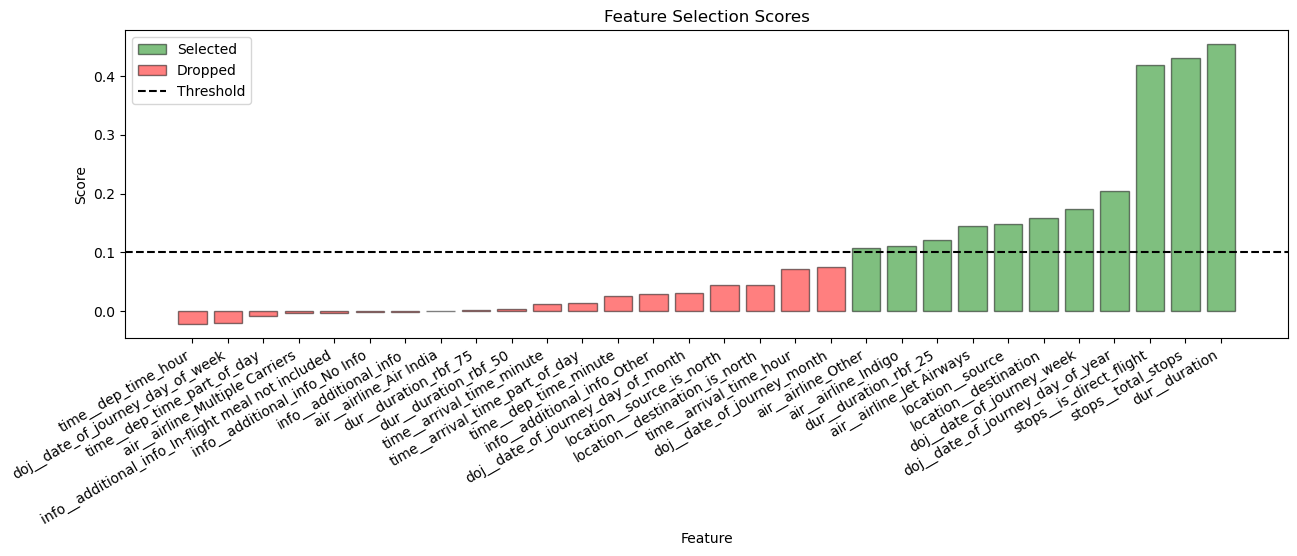

In [78]:
# showing dropout and not_dropout_feature using graph

THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- initially, the dataset has 31 columns
-but, after feature engineering(feature selection algorithm) ,it only select 11 columns out of 31 columns

## fit the preprocessor

In [82]:
preprocessor.fit(
    train.drop(columns="price"),
    train.price.copy()
)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('pipe2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001E06912B240>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [94]:
preprocessor.transform(train.drop(columns="price"))

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.941176,0.949153,-1.855189,-0.904387,-0.364072,-1.100128,0.0,1
1,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,-0.364072,1.444835,1.0,0
2,0.0,0.0,0.0,0.882353,0.872881,0.001513,-0.024692,-0.364072,1.835597,2.0,0
3,0.0,0.0,1.0,0.294118,0.262712,0.001513,-0.024692,-0.364072,1.915754,1.0,0
4,0.0,0.0,1.0,0.823529,0.822034,0.001513,-0.024692,-0.364072,0.853682,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.352941,0.355932,-1.066757,-1.786597,2.649340,-0.939815,0.0,1
636,0.0,1.0,0.0,0.588235,0.584746,0.001513,-0.024692,-0.364072,0.102217,1.0,0
637,1.0,0.0,0.0,0.647059,0.635593,-1.066757,-1.786597,-0.359672,-0.949835,0.0,1
638,0.0,0.0,0.0,0.647059,0.635593,1.010384,1.009568,-0.364072,0.192393,1.0,0


In [106]:
def get_file_name(name):
    return f"{name}-pre.csv"

In [108]:
import os

In [118]:
def export_data(data,name,pre):

   
    
    #split the data into x and y subsets
    x=data.drop(columns="price")
    y=data.price.copy()
    
    x_pre = pre.transform(x)

    #exporting
    file_name = get_file_name(name)
    (
        x_pre
        .join(y)
        .to_csv(file_name,index=True,header=True)
    )

In [120]:
export_data(train, "train", preprocessor)

In [128]:
test = pd.read_csv("test.csv")
test

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-03,Delhi,Cochin,18:15:00,01:35:00,440,1.0,No Info,18916
1,Jet Airways,2019-06-01,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,10262
2,Multiple Carriers,2019-06-06,Delhi,Cochin,07:05:00,16:10:00,545,1.0,No Info,9646
3,Air India,2019-03-24,Kolkata,Banglore,16:50:00,18:30:00,1540,1.0,No Info,14641
4,Multiple Carriers,2019-05-27,Delhi,Cochin,10:20:00,19:00:00,520,1.0,No Info,9794
...,...,...,...,...,...,...,...,...,...,...
195,Spicejet,2019-04-21,Kolkata,Banglore,06:55:00,09:30:00,155,0.0,No Info,4174
196,Multiple Carriers,2019-06-01,Delhi,Cochin,11:40:00,19:15:00,455,1.0,No Info,10261
197,Indigo,2019-03-21,Mumbai,Hyderabad,21:20:00,22:45:00,85,0.0,No Info,2227
198,Jet Airways,2019-06-03,Delhi,Cochin,16:00:00,12:35:00,1235,1.0,In-flight meal not included,10262


In [142]:
val = pd.read_csv("val.csv")

In [144]:
export_data(test, "test", preprocessor)

In [146]:
pd.read_csv("test-pre.csv")

,Unnamed: 0,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration,stops__total_stops,stops__is_direct_flight,price
0,0,0.0,0.0,0.0,0.764706,0.779661,1.010384,1.009568,-0.364072,2.984087,3.0,0,10703
1,1,0.0,0.0,0.0,0.000000,0.016949,1.010384,1.009568,-0.364072,1.514972,2.0,0,17266
2,2,0.0,0.0,0.0,0.058824,0.042373,-1.855189,-0.904387,-0.364072,0.653292,1.0,0,10366
3,3,0.0,0.0,1.0,0.823529,0.847458,0.001513,-0.024692,-0.364072,-0.368701,1.0,0,9495
4,4,0.0,1.0,0.0,0.823529,0.796610,1.010384,1.009568,-0.364072,1.374699,1.0,0,14714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,0.0,0.0,1.0,0.294118,0.279661,1.010384,1.009568,-0.364072,-0.739424,1.0,0,4098
156,156,0.0,0.0,1.0,0.000000,0.000000,-1.855189,-0.904387,-0.364072,-1.120167,0.0,1,12475
157,157,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,-0.364072,-0.228428,1.0,0,10197
158,158,0.0,1.0,0.0,0.000000,0.000000,-1.066757,-0.904387,-0.364072,1.835597,1.0,0,26890


In [148]:
export_data(val, "validation", preprocessor)

In [224]:
# Step 1: Load the preprocessed CSV files
train_data = pd.read_csv('train-pre.csv')
val_data = pd.read_csv('validation-pre.csv')
test_data = pd.read_csv('test-pre.csv')

# Step 2: Separate features (X) and labels (y)
X_train = train_data.iloc[:, 1:-1].values  # Features from train.csv
y_train = train_data.iloc[:, -1].values   # Flight prices from train.csv

X_val = val_data.iloc[:, 1:-1].values      # Features from val.csv
y_val = val_data.iloc[:, -1].values       # Flight prices from val.csv

X_test = test_data.iloc[:, 1:-1].values    # Features from test.csv
y_test = test_data.iloc[:, -1].values     # Flight prices from test.csv

In [230]:
X_train

array([[ 0.        ,  1.        ,  0.        , ..., -1.10012788,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.44483529,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.83559735,
         2.        ,  0.        ],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.94983478,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.19239278,
         1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.64327208,
         1.        ,  0.        ]])

In [232]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

In [234]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [236]:
print("\n--- Linear Regression ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_test, y_test)


--- Linear Regression ---
Mean Squared Error: 9518870.304278005
Mean Absolute Error: 2199.038381650632


In [238]:
pip install tensorflow

In [239]:
import tensorflow as tf

In [240]:
print("\n--- Neural Network (Deep Learning) ---")
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Linear output for regression
])


--- Neural Network (Deep Learning) ---


In [241]:
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
nn_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 95170368.0000 - mean_absolute_error: 8912.8643 - val_loss: 102495120.0000 - val_mean_absolute_error: 9031.8389
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 100378992.0000 - mean_absolute_error: 9038.3936 - val_loss: 102395088.0000 - val_mean_absolute_error: 9026.2949
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 92614424.0000 - mean_absolute_error: 8653.4951 - val_loss: 102159144.0000 - val_mean_absolute_error: 9013.5430
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104183368.0000 - mean_absolute_error: 9294.0615 - val_loss: 101678400.0000 - val_mean_absolute_error: 8987.8877
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 103214232.0000 - mean_absolute_error: 9220.7217 - val_loss: 100821904.0000 - val_mean_absolute_error: 8942.4482
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 102003648.0000 - mean_absolute_error: 9088.8516 - val_loss: 99418448.0000 - val_mean_ab

In [242]:
nn_loss, nn_mae = nn_model.evaluate(X_test, test_data.iloc[:, -1].values)
print(f"Neural Network Test Mean Absolute Error: {nn_mae}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9095453.0000 - mean_absolute_error: 2311.0576
Neural Network Test Mean Absolute Error: 2391.14111328125


In [243]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [244]:
lr.predict(X_test)

array([13892.3319708 , 14039.74040716, 10675.89889834,  8314.68928832,
       11125.28384172,  9855.82235211,  8994.03190569,  9949.45112924,
        8594.68623864,  7685.95526186,  8427.19369018,  3346.75329597,
        8167.73718733,  7772.4963691 , 11275.78681248, 13385.10253248,
        5436.05548251,  8696.54525539,  8153.15186116,  8864.42601417,
        4529.65270118, 10467.38355591,  5635.68833954,  9011.7465173 ,
        3403.86424403,  9493.57240381,  2884.03167729,  3353.68288396,
        8136.91346719, 13546.18149122,  8108.06141578,  6046.34638163,
        3755.30649681,  9524.20803536, 11968.54997112,  9433.04748081,
       11506.74087334, 11241.85478406,  9741.39951827,  7282.65111187,
       11482.63928823, 10044.77820928,  7953.21433213, 11739.48289786,
       14140.53001697,  9400.50701438, 13298.53638373, 10246.01510577,
        6990.0234462 ,  3330.89018247,  9854.29588372, 11676.77516669,
       12772.18292303, 12467.91834215,  8646.35102948, 11550.19661471,
      

In [272]:
lr_score= r2_score(y_test,lr.predict(X_test))
lr_score

0.5449888598894921

In [274]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor
from xgboost import XGBRegressor

In [276]:
# pick different model and test which is better 
Linear_reg = LinearRegression(),
Ride_reg= Ridge()
XGBoost = XGBRegressor()
Random_forest = RandomForestRegressor()
Ada_boost = AdaBoostRegressor()
Grad_boost = GradientBoostingRegressor()
Bagging= BaggingRegressor()   

In [278]:
model_li = [Ride_reg,XGBoost,Random_forest,Ada_boost,Grad_boost,Bagging]

In [280]:
Score =[]
for model in model_li:
    model.fit(X_train,y_train)
    Score.append(r2_score(y_test,model.predict(X_test)))

In [281]:
Score.append(lr_score) 

In [282]:
Score

[0.5396745036740965,
 0.7214763760566711,
 0.6900680225409925,
 0.5939710453495974,
 0.7196115114073522,
 0.6645728363223737,
 0.5449888598894921]

In [ ]:
scalar=MinMaxScaler()
scaler.fit()

In [294]:
train_data=train_data.drop(columns="Unnamed: 0")

In [296]:
train_data

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration,stops__total_stops,stops__is_direct_flight,price
0,0.0,1.0,0.0,0.941176,0.949153,-1.855189,-0.904387,-0.364072,-1.100128,0.0,1,4995
1,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,-0.364072,1.444835,1.0,0,8372
2,0.0,0.0,0.0,0.882353,0.872881,0.001513,-0.024692,-0.364072,1.835597,2.0,0,6117
3,0.0,0.0,1.0,0.294118,0.262712,0.001513,-0.024692,-0.364072,1.915754,1.0,0,7770
4,0.0,0.0,1.0,0.823529,0.822034,0.001513,-0.024692,-0.364072,0.853682,1.0,0,9187
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.352941,0.355932,-1.066757,-1.786597,2.649340,-0.939815,0.0,1,4282
636,0.0,1.0,0.0,0.588235,0.584746,0.001513,-0.024692,-0.364072,0.102217,1.0,0,13067
637,1.0,0.0,0.0,0.647059,0.635593,-1.066757,-1.786597,-0.359672,-0.949835,0.0,1,4423
638,0.0,0.0,0.0,0.647059,0.635593,1.010384,1.009568,-0.364072,0.192393,1.0,0,7670


In [306]:
input_dataset = ["air__airline_Indigo","air__airline_Jet Airways","air__airline_Other","doj__date_of_journey_week","doj__date_of_journey_day_of_year","location__source","location__destination","dur__duration_rbf_25","dur__duration","stops__total_stops","stops__is_direct_flight"]
target_col=["price"]

In [316]:
input_dataset = pd.DataFrame(input_dataset)

In [318]:
numeric_cols = input_dataset.select_dtypes(include=np.number).columns.tolist()
categorical_cols = input_dataset.select_dtypes(include='object').columns.tolist()

In [358]:
X = train_data.iloc[:, 1:-1]  
y = train_data.iloc[:, -1] 

In [360]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)

In [362]:
lr.fit(xtrain,ytrain)

LinearRegression()

In [364]:
lr_score= r2_score(ytest,lr.predict(xtest))
lr_score

0.5348257831431817

In [366]:
train.rea

AttributeError: 'DataFrame' object has no attribute 'rea'

In [368]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [369]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [375]:
scores = cross_val_score(LinearRegression(), X, y, cv=cv, scoring='accuracy')
scores

array([nan, nan, nan, nan, nan])